# EV3 Character Recognition Experiment - Predict

1. Load machine learning model
2. Prompt the user to place a character on the lego rotating platform
3. Run character scan experiment on EV3
4. Transfer logged data file from EV3 to PC
5. Process raw data - clean and categorise into rotation buckets
6. Predict character using ML model
7. Show and say predicted value on EV3 
8. Plot graphs of rotation vs reflectivity (including mean and median plots) in Notebook

## Run experiment on EV3 and return datalog file

In [306]:
import subprocess
from subprocess import call
from IPython.display import Markdown as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [307]:
# Load machine learning (kNN) model

knn_model = pickle.load(open('./ml_model/number_reflectivity_knn_model', 'rb'))

In [308]:
def get_prediction_data(logfile, rotations=10, interval=40):
    '''Scan character on reflectivity platform'''

    print(f'Place character on the platform')

    # Execute the 'main.py' script on the ev3. Existing logs (prefixed <filename> are deleted first)
    call(["ssh", "ev3", f"cd ./number_predict; rm {logfile}*; \
          brickrun -r -- pybricks-micropython main.py --interval {interval} --rotations {rotations} --filename {logfile}"])

    # Copy the results log generated by the script back to the local PC
    subprocess.run(["scp", f"ev3:~/number_predict/{logfile}*", "./raw_data"])

    print(f'  - Character has been scanned')

In [309]:
rotations = 3
filename = 'predict'

get_prediction_data(logfile=filename, rotations=rotations)

Place character on the platform
  - Character has been scanned


## Process raw data results

In [310]:
# Get location and name of latest prediction file from the list of '<filename>' files in current directory
prediction_file = !ls ./raw_data | grep -e $filename
prediction_file = prediction_file[-1]
!pwd
print(prediction_file)

/Users/garry/documents/github/datapiquing/lego/character recognition/ev3/number_predict
predict_2020_04_12_12_55_25_337274.csv


In [311]:
# Read the prediction data into a DataFrame
df_predict = pd.read_csv(f'./raw_data/{prediction_file}', index_col=False)
df_predict.head(10)

,angle,reflectivity
0,5,8
1,14,8
2,23,8
3,32,7
4,41,7
5,50,7
6,60,7
7,69,7
8,78,6
9,87,6


In [312]:
# Get the DataFrame dimensions
df_predict.shape

(120, 2)

In [313]:
# Get information about the datalog DataFrame
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   angle          120 non-null    int64
 1    reflectivity  120 non-null    int64
dtypes: int64(2)
memory usage: 2.0 KB


In [314]:
df_predict.columns

Index(['angle', ' reflectivity'], dtype='object')

In [315]:
# Remove the space that prefixes the 'reflectivity' column name
df_predict.columns = ['angle', 'reflectivity']

In [316]:
def create_rotation_dict():
    '''Initialise a dictionary with keys of 0 to 360 at 10 degree intervals, each with value zero'''
    degree_bins = list(range(0,361,10))
    rotation_dict = {}
    for bin in degree_bins:
        rotation_dict[bin] = 0
    return rotation_dict

In [317]:
# A function to place rotation values into buckets of 10 degrees (+ or - 5 degrees either side)
# These will be the feature columns of each sample rotation

def rotation_buckets(degrees):
    '''Calculate which 360 degree bucket (width=10) the rotation belongs'''
    if degrees > 360 and degrees%360 < 5:
        degrees = (degrees - 5)%360
    else:
        degrees = degrees%360
    modulus = degrees%10
    if modulus < 5:
        bucket = degrees - modulus
    else:
        bucket = (degrees - modulus) + 10
    return bucket

In [318]:
def create_clean_dataframe(raw_prediction_dataframe):
    '''Preprocess raw prediction data'''
    
    df_raw_data = raw_prediction_dataframe
    
    # The experiment was 1 run of X x 360 degree rotations
    # Put actual rotation angle into buckets of 10 degrees between 0 and 360 degrees
    # Concatenate each run of X rotations vertically as tuples of (bucket_degrees, reflectivity_percentage)

    results_list = []
    rotation_column = 'angle'
    reflectivity_column = 'reflectivity'
    for index, row in df_raw_data.iterrows():
        prev_bucket_degrees = -1
        actual_degrees = row[rotation_column]
        bucket_degrees = rotation_buckets(actual_degrees)
        relectivity_percentage = row[reflectivity_column]
        #print(actual_degrees, bucket_degrees, relectivity_percentage)
        results_list.append((bucket_degrees, relectivity_percentage))
        
    # Convert the list of result tuples (rotation angle, refelctivity) to a dictionary of dictionaries where
    # the key is the run number and the value is a dictionary of rotation angles (from 0 to 360 degrees at 
    # 10 degree intervals) and their respective reflectivity value

    run = 0
    results = {}
    dict = create_rotation_dict()
    at_360 = False
    for tuple in results_list:
        if tuple[0] < 360 or at_360 == False:
            dict[tuple[0]] = tuple[1]    
            if tuple[0] >= 360:
                results[run] = dict
                run += 1
                dict = create_rotation_dict()

        at_360 = (tuple[0] >= 360) 
        
    # Create a DataFrame from the angle vs reflectivity results

    df_results = pd.DataFrame.from_dict(results)
    
    # Transpose the DataFrame so each rotation sample is a row and each 10 degree angle of rotation 
    # between 0 and 360 degrees is a feature column

    df_results = df_results.transpose()
    
    # Impute and zero values
    # For angles 0 - 10 degrees use the value of 360 degrees

    df_results[0] = np.where(df_results[0] == 0, df_results[360], df_results[0])
    
    # Where a cell value is zero convert to NaN

    df_results[df_results.eq(0)] = np.nan
    
    # Replace NaN values with the column mean

    df_results.fillna(df_results.mean().astype(int), inplace=True)
    df_results = df_results.astype(int)
    
    # Export the number DataFrame to a .csv file
    df_results.to_csv('./clean_data/prediction_dataset.csv', index=False)
    
    return df_results

In [319]:
# Pre-process the raw data for the ML model
df_clean_prediction_data = create_clean_dataframe(df_predict)

## Predict Character

### Alternative approaches to getting a single prediction value
1. Use all n rows in the cleaned prediction dataset (X_pred) to return a NumPy array of n predictions (y_pred), e.g. [4 4 4 5]
    - then take the first prediction, y_pred[0] or the most frequently occurring prediction in y_pred
2. Use the median of all columns in the cleaned prediction dataset (X_pred) to return a single prediction (y_pred), e.g. [4]

In [320]:
# Option 1
#X_pred = df_clean_prediction_data
#X_pred

In [321]:
# Option 2
X_pred = df_clean_prediction_data
X_pred = X_pred.median().to_frame().transpose()
X_pred

,0,10,20,30,40,50,60,70,80,90,...,270,280,290,300,310,320,330,340,350,360
0,7.0,8.0,8.0,7.0,8.0,7.0,7.0,6.0,6.0,6.0,...,4.0,4.0,4.0,5.0,6.0,6.0,6.0,6.0,7.0,7.0


In [322]:
# Predict the character (target value) represented by each row of feature reflectivity values
# N.B. This returns a NumPy array not a list
y_pred = knn_model.predict(X_pred)

In [323]:
# Instead of setting the cell to Markdown, create Markdown from withnin a code cell!
# We can just use python variable replacement syntax to make the text dynamic
n = 10
md(f"# Test set prediction: {y_pred}")

# Test set prediction: [8]

In [324]:
# Option 1 & 2
result = y_pred[0]

In [325]:
call(["ssh", "ev3", f"cd ./number_predict; \
      brickrun -r -- pybricks-micropython main.py --predict {result}"])

0

## Plot Angle of Rotation vs Reflectivity

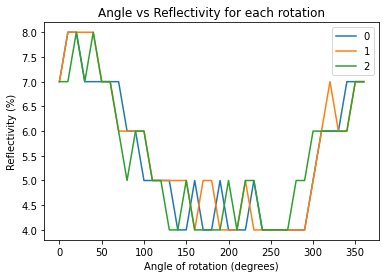

In [326]:
# Plot all X rotations on the same graph of rotation vs reflectivity

df_clean_prediction_data.transpose().plot(legend=False)
plt.legend()
plt.title('Angle vs Reflectivity for each rotation')
plt.xlabel('Angle of rotation (degrees)')
plt.ylabel('Reflectivity (%)')
plt.show()

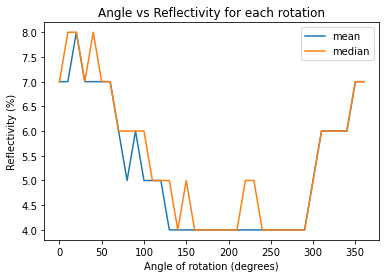

In [327]:
df_clean_prediction_data.mean().astype(int).plot(label = 'mean')
df_clean_prediction_data.median().astype(int).plot(label = 'median')
plt.legend()
plt.title('Angle vs Reflectivity for each rotation')
plt.xlabel('Angle of rotation (degrees)')
plt.ylabel('Reflectivity (%)')
plt.show()

In [328]:
# Could take the most frequently occurring prediction as the result
# Alternatively, analyse one row of just the mean or median values

In [329]:
# 4 is predicted incorrectly

In [330]:
# Display the training graph against the result graph
# Use different machine learning models
# Use different hyperparameters - construct graphs of values vs accuracy
# Some error handling or printed output from the subprocess commands
# Train model with much more data
# Train full alphabet - upper and lowecase
# Train using horizontal/vertical scan instead of rotational scan ... feed letters in via horizontal moving conveyor 
# or down/up a vertical guide
# Predict as each character passes on conveyor and display on brick

## Need to fix the error with reduced rows due to missing 369